# Data Science for Business

## Spring 2020, module 4 @ HSE

---

## Home assignment 5


Author: **Miron Rogovets**

---

You goal for this task is two fold:

1. Cluster all the products into distinct groups (clusters)
2. Build a recommender system for customers, but instead of products we will recommend categories.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

In [2]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('data/sample_transations.csv', index_col=0)
df.head(3)

,dd_card_number,store_number,dd_transaction_number,sku,quantity,post_discount_price,date,hour,dbi_item_catgry,dbi_item_sub_catgry,dbi_item_famly_name,dbi_item_size
0,0,775,7969,74,1,2.29,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Large
1,0,775,7969,73,1,0.00,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Medium
2,0,761,16021,75,1,2.49,9/4/2015,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large


In [4]:
df.shape

(51939, 12)

In [5]:
df.dtypes

dd_card_number             int64
store_number               int64
dd_transaction_number      int64
sku                        int64
quantity                   int64
post_discount_price      float64
date                      object
hour                      object
dbi_item_catgry           object
dbi_item_sub_catgry       object
dbi_item_famly_name       object
dbi_item_size             object
dtype: object

In [6]:
df.isna().sum()

dd_card_number           0
store_number             0
dd_transaction_number    0
sku                      0
quantity                 0
post_discount_price      0
date                     0
hour                     0
dbi_item_catgry          0
dbi_item_sub_catgry      0
dbi_item_famly_name      0
dbi_item_size            0
dtype: int64

- `dd_card_number` - customer identifier (categorical)
- `store_number` - store identifier (categorical)
- `dd_transaction_number` - transaction identifier (categorical)
- `sku` - product identifier, may vary across different stores (categorical)
- `quantity` - quantity (numerical)
- `post_discount_price` - transaction price (numerical)
- `date` - transaction date 
- `hour` (categorical)
- `dbi_item_catgry` (categorical)
- `dbi_item_sub_catgry` (categorical)
- `dbi_item_famly_name` (categorical)
- `dbi_item_size` (categorical)


### Data Exploration

In [7]:
df.duplicated().sum()

1273

In [8]:
df.drop_duplicates(inplace=True)
df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek
df.shape

(50666, 13)

In [9]:
df.nunique()

dd_card_number             100
store_number              1501
dd_transaction_number    24348
sku                        620
quantity                    11
post_discount_price        556
date                       365
hour                         4
dbi_item_catgry              5
dbi_item_sub_catgry         55
dbi_item_famly_name        120
dbi_item_size              103
weekday                      7
dtype: int64

In [10]:
original_features = df.columns
original_features

Index(['dd_card_number', 'store_number', 'dd_transaction_number', 'sku',
       'quantity', 'post_discount_price', 'date', 'hour', 'dbi_item_catgry',
       'dbi_item_sub_catgry', 'dbi_item_famly_name', 'dbi_item_size',
       'weekday'],
      dtype='object')

In [11]:
df['dbi_item_catgry'].value_counts()

Beverages        30004
Food - Bakery    13786
Food AM           6181
Food PM            427
Other              268
Name: dbi_item_catgry, dtype: int64

In [12]:
df['hour'].value_counts()

Morning      29029
Lunch        14294
Afternoon     5467
Night         1876
Name: hour, dtype: int64

In [13]:
df['dbi_item_sub_catgry'].value_counts()

Hot Coffee                                 15648
Iced Coffee                                 8882
Donut Varieties                             6254
Bagels                                      3880
Muffin                                      3117
Wake Up Wraps                               2226
Hash Brown                                  1139
Iced Espresso                               1121
Iced Tea                                    1036
Frozen Beverages                             805
Hot Espresso                                 744
Cooler Beverages                             683
Bacon, Egg & Cheese                          658
Hot Tea                                      625
Egg & Cheese                                 596
Sausage, Egg & Cheese                        532
Other Hot Beverages                          451
Other Food- Bakery                           413
Egg White Flatbreads                         335
Turkey Sausage Sandwich                      275
K-Cups              

In [14]:
(df['post_discount_price'] == 0.0).sum()

7305

In [15]:
skus = df.groupby('dbi_item_famly_name')[['sku', 'store_number', 'dbi_item_size']].nunique()
skus[skus.sku > 1]

,sku,store_number,dbi_item_size
dbi_item_famly_name,,,
1 Fried Egg,2,4,1
1 lb,3,15,1
2 Fried Eggs (Big n Toasted),3,19,1
Almond Milk,8,42,1
Apparel,2,2,1
...,...,...,...
"Yellow, Scrambled Egg (Ham, Egg & Cheese)",10,45,5
"Yellow, Scrambled Egg (Maple Sausage Breakfast Sandwich)",3,15,3
"Yellow, Scrambled Egg (Sausage, Egg & Cheese)",15,147,6


---

### I. Clustering (20)

1. Feature generation. Use examples from Seminar 6 Plan to generate features for products clustering. You may generate any number of features but you must generate at least 3 features which differ from those, proposed in the plan.

In [16]:
# seminar features

# Mean item price
data = pd.DataFrame(df.groupby('sku')['post_discount_price'].mean())
data.rename(columns={"post_discount_price": "mean_price"}, inplace=True)

# median quantity in a single purchase
data['med_purchase_quantity'] = df.groupby(['dd_transaction_number', 'sku'])['quantity'].median() \
.groupby('sku').first()

# How many different stores sell this item
data['store_count'] = df.groupby('sku')['store_number'].nunique()

# How many different customers buy this item
# data['cust_count'] = df.groupby('sku')['dd_card_number'].nunique()

# Number of other items in the same subcategory
df['subcat_size'] = df.groupby('dbi_item_sub_catgry')['sku'].transform('nunique') - 1 
data['subcat_size'] = df.groupby('sku')['subcat_size'].first()

# Average price of items in the same category
df['subcat_price'] = df.groupby('dbi_item_sub_catgry')['post_discount_price'].transform('mean')
data['subcat_price'] = df.groupby('sku')['subcat_price'].first()

# custom features

# how often item is purchased (days with purchases / total days)
df['freq'] = df.groupby(['sku'])['date'].transform('nunique') / df.date.nunique()
data['freq'] = df.groupby('sku')['freq'].first()

# Number of other items in the same family
df['fam_size'] = df.groupby('dbi_item_famly_name')['sku'].transform('nunique') - 1 
data['fam_size'] = df.groupby('sku')['fam_size'].first()

# Average price of items in the same family
df['fam_price'] = df.groupby('dbi_item_famly_name')['post_discount_price'].transform('mean')
data['fam_price'] = df.groupby('sku')['fam_price'].first()

data.head(3)

,mean_price,med_purchase_quantity,store_count,subcat_size,subcat_price,freq,fam_size,fam_price
sku,,,,,,,,
0,0.00,1.00,1,12,1.23,0.01,4,0.08
1,0.00,1.00,11,12,1.23,0.06,4,0.08
2,0.00,1.00,1,84,1.52,0.00,41,1.31


In [17]:
week_ratios = df.groupby(['sku', 'weekday'])['dd_transaction_number'].nunique()
purchases = df.groupby(['sku'])['dd_transaction_number'].nunique()

mon = week_ratios[week_ratios.index.get_level_values(1) == 0]
tue = week_ratios[week_ratios.index.get_level_values(1) == 1]
wed = week_ratios[week_ratios.index.get_level_values(1) == 2]
thu = week_ratios[week_ratios.index.get_level_values(1) == 3]
fri = week_ratios[week_ratios.index.get_level_values(1) == 4]
sat = week_ratios[week_ratios.index.get_level_values(1) == 5]
sun = week_ratios[week_ratios.index.get_level_values(1) == 6]

data['mon_ratio'] = mon.values / purchases[mon.index.get_level_values(0)]
data['tue_ratio'] = tue.values / purchases[tue.index.get_level_values(0)]
data['wed_ratio'] = wed.values / purchases[wed.index.get_level_values(0)]
data['thu_ratio'] = thu.values / purchases[thu.index.get_level_values(0)]
data['fri_ratio'] = fri.values / purchases[fri.index.get_level_values(0)]
data['sat_ratio'] = sat.values / purchases[sat.index.get_level_values(0)]
data['sun_ratio'] = sun.values / purchases[sun.index.get_level_values(0)]

In [18]:
hours = df.groupby(['sku', 'hour'])['dd_transaction_number'].nunique()
morning = hours[hours.index.get_level_values(1) == 'Morning']
lunch = hours[hours.index.get_level_values(1) == 'Lunch']
afternoon = hours[hours.index.get_level_values(1) == 'Afternoon']
night = hours[hours.index.get_level_values(1) == 'Night']

data['morning_purchase_ratio'] = morning.reset_index().set_index('sku') \
['dd_transaction_number'] / purchases[morning.index.get_level_values(0)]
data['lunch_purchase_ratio'] = lunch.reset_index().set_index('sku') \
['dd_transaction_number'] / purchases[lunch.index.get_level_values(0)]
data['afternoon_purchase_ratio'] = afternoon.reset_index().set_index('sku') \
['dd_transaction_number'] / purchases[afternoon.index.get_level_values(0)]
data['night_purchase_ratio'] = night.reset_index().set_index('sku') \
['dd_transaction_number'] / purchases[night.index.get_level_values(0)]

data.head(3)

,mean_price,med_purchase_quantity,store_count,subcat_size,subcat_price,freq,fam_size,fam_price,mon_ratio,tue_ratio,wed_ratio,thu_ratio,fri_ratio,sat_ratio,sun_ratio,morning_purchase_ratio,lunch_purchase_ratio,afternoon_purchase_ratio,night_purchase_ratio
sku,,,,,,,,,,,,,,,,,,,
0,0.00,1.00,1,12,1.23,0.01,4,0.08,nan,0.50,nan,nan,nan,0.50,nan,1.00,nan,nan,nan
1,0.00,1.00,11,12,1.23,0.06,4,0.08,0.17,0.12,0.12,0.21,0.17,0.12,0.08,0.88,0.08,0.04,nan
2,0.00,1.00,1,84,1.52,0.00,41,1.31,nan,nan,nan,nan,nan,1.00,nan,1.00,nan,nan,nan


In [19]:
data.isna().sum()

mean_price                    0
med_purchase_quantity         0
store_count                   0
subcat_size                   0
subcat_price                  0
freq                          0
fam_size                      0
fam_price                     0
mon_ratio                   294
tue_ratio                   269
wed_ratio                   289
thu_ratio                   277
fri_ratio                   265
sat_ratio                   247
sun_ratio                   284
morning_purchase_ratio      133
lunch_purchase_ratio        196
afternoon_purchase_ratio    311
night_purchase_ratio        457
dtype: int64

In [20]:
data.fillna(0, inplace=True)

2. Cluster all products into distinct groups (clusters). You may use any clustering algorithm you want. If you use distance-based clustering (e.g. k-means), do not forget to preprocess your features (normalization, z-scoring or standard scaling). Try a different number of groups (e.g. from 5 to 30)

In [21]:
data.columns

Index(['mean_price', 'med_purchase_quantity', 'store_count', 'subcat_size',
       'subcat_price', 'freq', 'fam_size', 'fam_price', 'mon_ratio',
       'tue_ratio', 'wed_ratio', 'thu_ratio', 'fri_ratio', 'sat_ratio',
       'sun_ratio', 'morning_purchase_ratio', 'lunch_purchase_ratio',
       'afternoon_purchase_ratio', 'night_purchase_ratio'],
      dtype='object')

In [22]:
data.dtypes

mean_price                  float64
med_purchase_quantity       float64
store_count                   int64
subcat_size                   int64
subcat_price                float64
freq                        float64
fam_size                      int64
fam_price                   float64
mon_ratio                   float64
tue_ratio                   float64
wed_ratio                   float64
thu_ratio                   float64
fri_ratio                   float64
sat_ratio                   float64
sun_ratio                   float64
morning_purchase_ratio      float64
lunch_purchase_ratio        float64
afternoon_purchase_ratio    float64
night_purchase_ratio        float64
dtype: object

In [23]:
data.isna().sum().sum()

0

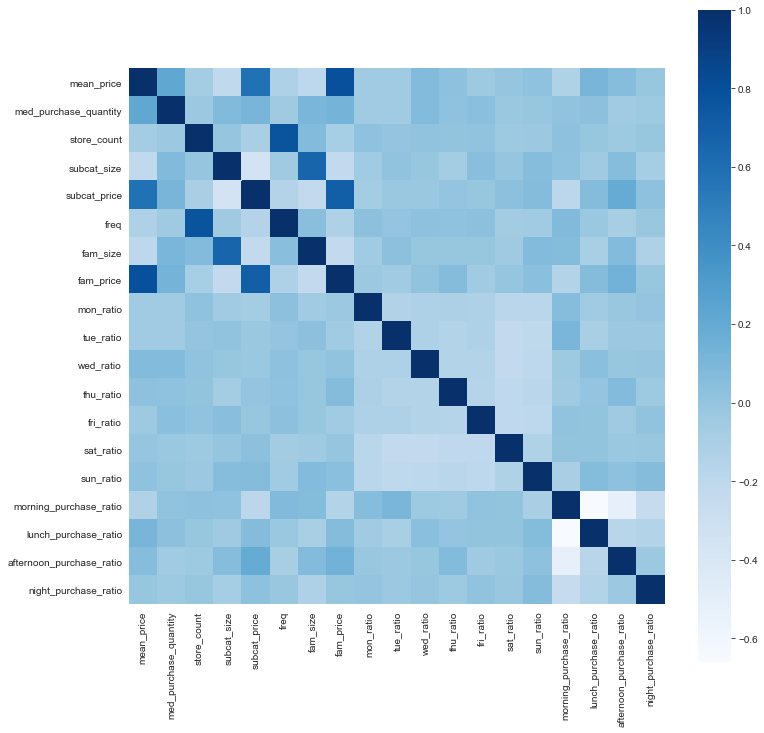

In [24]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), square = True, cmap='Blues')

In [25]:
(~data.corr()[abs(data.corr()) > 0.85].isna()).sum()

mean_price                  1
med_purchase_quantity       1
store_count                 1
subcat_size                 1
subcat_price                1
freq                        1
fam_size                    1
fam_price                   1
mon_ratio                   1
tue_ratio                   1
wed_ratio                   1
thu_ratio                   1
fri_ratio                   1
sat_ratio                   1
sun_ratio                   1
morning_purchase_ratio      1
lunch_purchase_ratio        1
afternoon_purchase_ratio    1
night_purchase_ratio        1
dtype: int64

In [66]:
data.shape

(620, 19)

We do not have highly correlated variables, so we can proceed with clusterization

In [26]:
scaler = MinMaxScaler()
scaled = data.copy()
scaled[scaled.columns] = scaler.fit_transform(scaled[scaled.columns])
scaled.head()

,mean_price,med_purchase_quantity,store_count,subcat_size,subcat_price,freq,fam_size,fam_price,mon_ratio,tue_ratio,wed_ratio,thu_ratio,fri_ratio,sat_ratio,sun_ratio,morning_purchase_ratio,lunch_purchase_ratio,afternoon_purchase_ratio,night_purchase_ratio
sku,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.14,0.05,0.00,0.10,0.00,0.00,0.50,0.00,0.00,0.00,0.50,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,0.02,0.14,0.05,0.06,0.10,0.00,0.17,0.12,0.12,0.21,0.17,0.12,0.08,0.88,0.08,0.04,0.00
2,0.00,0.00,0.00,1.00,0.07,0.00,1.00,0.03,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.40,0.04,1.00,0.07,0.09,1.00,0.03,0.03,0.06,0.19,0.11,0.22,0.19,0.19,0.67,0.33,0.00,0.00
4,0.00,0.00,0.00,1.00,0.07,0.01,1.00,0.03,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.75,0.25,0.00,0.00


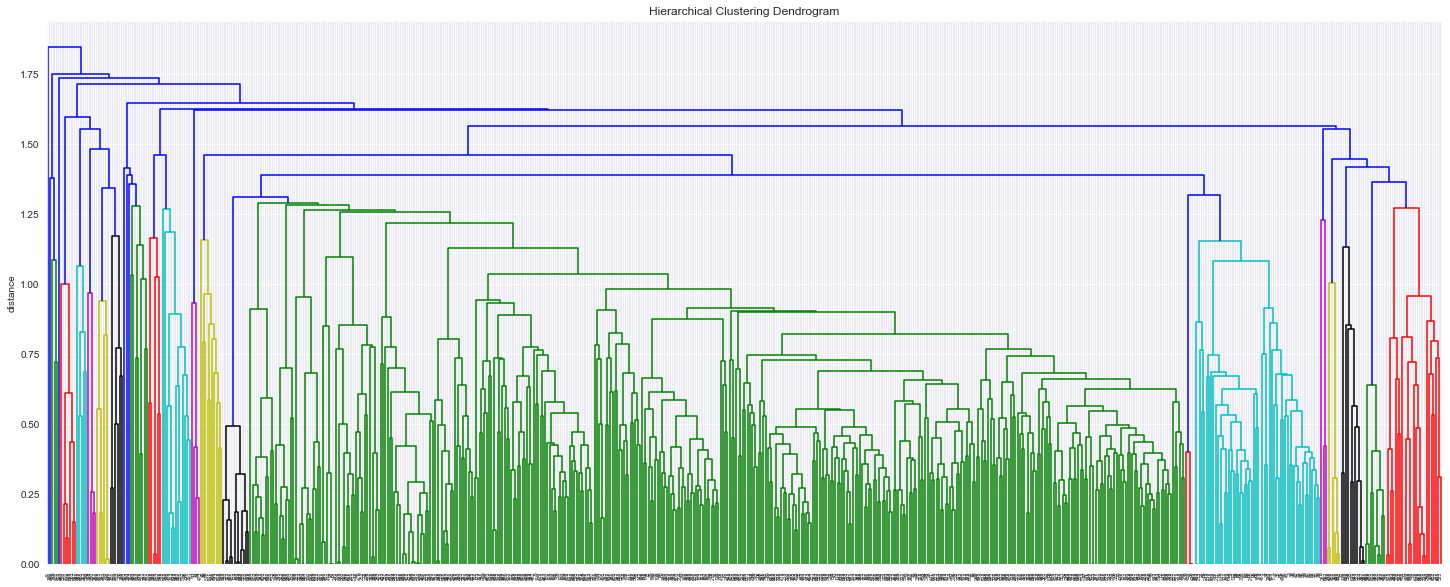

In [27]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram = sch.dendrogram(sch.linkage(scaled, method='average'))
plt.ylabel('distance')
plt.show()

In [28]:
sums = []
K = range(1,80)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(scaled)
    sums.append(km.inertia_)

100%|██████████| 79/79 [00:23<00:00,  3.38it/s]


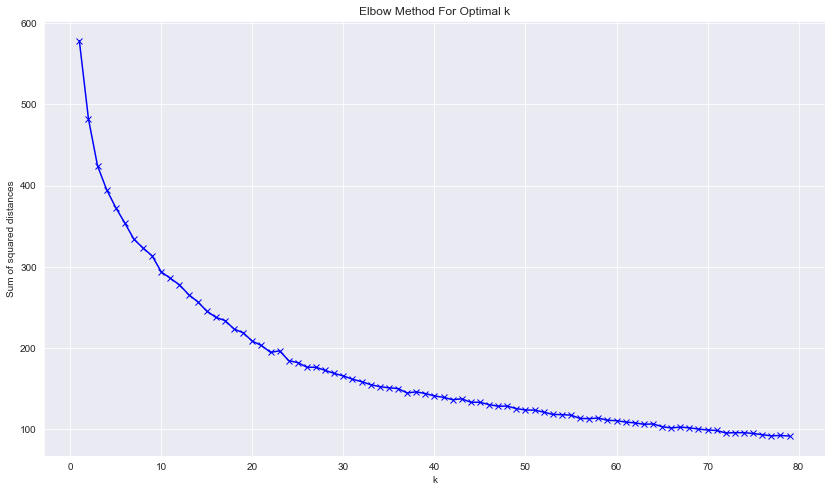

In [29]:
plt.figure(figsize=(14,8))
plt.plot(K, sums, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
for k in tqdm([15, 20, 25, 30, 35]):
    kmeans = KMeans(n_clusters=k)
    predicted = kmeans.fit_predict(scaled)
    scaled[f'kmeans_{k}'] = predicted

100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


In [31]:
scaled.head(4)

,mean_price,med_purchase_quantity,store_count,subcat_size,subcat_price,freq,fam_size,fam_price,mon_ratio,tue_ratio,...,sun_ratio,morning_purchase_ratio,lunch_purchase_ratio,afternoon_purchase_ratio,night_purchase_ratio,kmeans_15,kmeans_20,kmeans_25,kmeans_30,kmeans_35
sku,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.14,0.05,0.00,0.10,0.00,0.00,0.50,...,0.00,1.00,0.00,0.00,0.00,7,9,2,19,12
1,0.00,0.00,0.02,0.14,0.05,0.06,0.10,0.00,0.17,0.12,...,0.08,0.88,0.08,0.04,0.00,13,3,19,6,6
2,0.00,0.00,0.00,1.00,0.07,0.00,1.00,0.03,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,9,8,12,25,1
3,0.00,0.40,0.04,1.00,0.07,0.09,1.00,0.03,0.03,0.06,...,0.19,0.67,0.33,0.00,0.00,9,8,12,25,1


3. Write a report. In your report you should present the following information:
   - Put an example screenshot of your features.
   - Explain (in a similar way I explain them in the plan) every single feature (you may skip features from the seminar plan) you use.
   - Cluster’s information: how many clusters do you have, how many objects are in these clusters.
   - Cluster’s interpretation. Try to provide an interpretation of every single cluster (or groups of clusters) you end up. For example: “Cluster 1 includes hot drinks and beverages often bought in a combination in the morning.”
   - You may include any visualization you find necessary, e.g.: colored PCA components, histogram or pie charts of cluster’s sizes, “elbows” used for selection number of clusters (if you have used it).


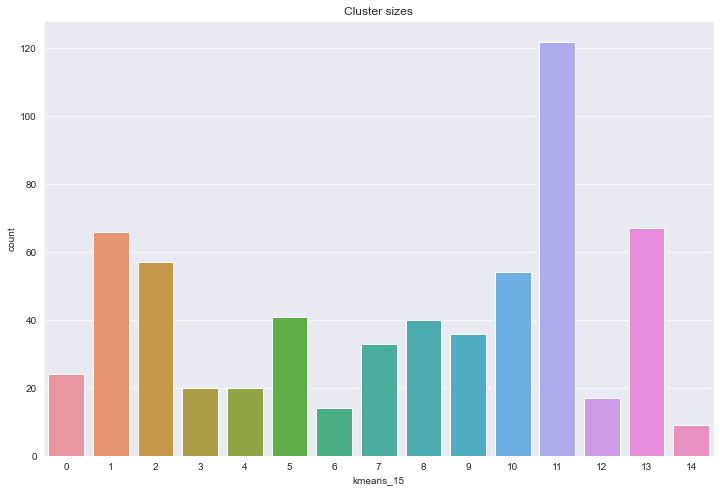

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(scaled['kmeans_15']).set_title('Cluster sizes')
plt.show()

In [59]:
def describe_cluster(k, data, original_data, labels):
    
    hour_ratio = ['morning_purchase_ratio', 'lunch_purchase_ratio', 
                  'afternoon_purchase_ratio', 'night_purchase_ratio']
    weekday_ratio = ['mon_ratio', 'tue_ratio', 'wed_ratio', 
                     'thu_ratio', 'fri_ratio', 'sat_ratio', 'sun_ratio']
    
    print('======================================================================================================')
    print(f'Cluster number: {k}')
    cluster = data[labels == k]
    
    data_slice = original_data[original_data.sku.isin(cluster.index)][
        ['sku', 'dd_card_number', 'hour', 'dbi_item_catgry', 
         'dbi_item_sub_catgry', 'dbi_item_famly_name', 'dbi_item_size']
    ]
    
    print(f'Cluster size: {cluster.shape[0]}\n')
    print(f"Mean price: {cluster['mean_price'].mean():.3f}")
    print(f"Mean stores count: {cluster['store_count'].mean():.3f}")
    print(f"Mean freq: {cluster['freq'].mean():.3f}\n")
    print(f"Mean customers count: {data_slice.groupby('sku')['dd_card_number'].nunique().mean():.3f}")
    
    f, ax = plt.subplots(4,2, figsize=(12, 18))
    sns.countplot(data_slice.groupby('sku')['dbi_item_catgry'].first(), ax=ax[0,0]).set_title('Categories')
    
    
    subcat = data_slice.groupby('sku')['dbi_item_sub_catgry'].first()
    subcat_idx = subcat.value_counts()[:6].index
    fam = data_slice.groupby('sku')['dbi_item_famly_name'].first()
    fam_idx = fam.value_counts()[:6].index
    sizes = data_slice.groupby('sku')['dbi_item_size'].first()
    sizes_idx = sizes.value_counts()[:6].index
    
    sns.countplot(subcat.where(subcat.isin(subcat_idx), 'other'), ax=ax[0, 1]).set_title('Top subategories')
    sns.countplot(fam.where(fam.isin(fam_idx), 'other'), ax=ax[1, 0]).set_title('Top family names')
    sns.countplot(sizes.where(sizes.isin(sizes_idx), 'other'), ax=ax[1,1]).set_title('Product sizes')
    
    hours = cluster[hour_ratio].mean().rename(lambda x: x.split('_')[0])
    weeks = cluster[weekday_ratio].mean().rename(lambda x: x.split('_')[0])

    sns.barplot(x=hours.index, y=hours.values, ax=ax[2,0]).set_title('Hours ratio')
    sns.barplot(x=weeks.index, y=weeks.values, ax=ax[2,1]).set_title('Weekdays ratio')
    
    sns.distplot(cluster['mean_price'], kde=False, rug=True, ax=ax[3,0]).set_title('Price distribution')
    sns.distplot(cluster['freq'], kde=False, rug=True, ax=ax[3,1]).set_title('Frequency distribution')
    
    for ax in f.axes[:-1]:
        if len(ax.xaxis.get_ticklabels()) > 4:
            plt.sca(ax)
            plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('======================================================================================================')

Cluster number: 0
Cluster size: 24

Mean price: 3.793
Mean stores count: 1.333
Mean freq: 0.005

Mean customers count: 1.292


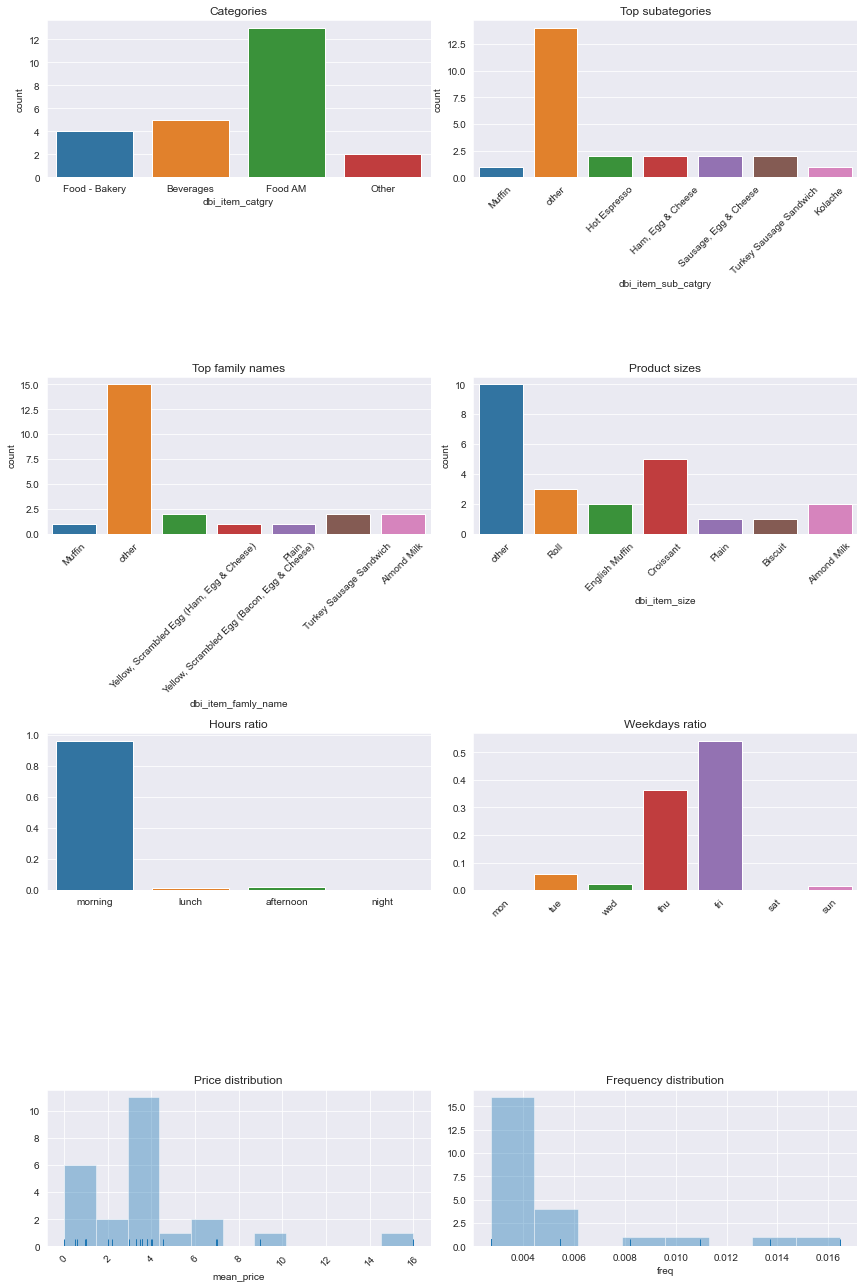

Cluster number: 1
Cluster size: 66

Mean price: 1.911
Mean stores count: 13.348
Mean freq: 0.074

Mean customers count: 8.621


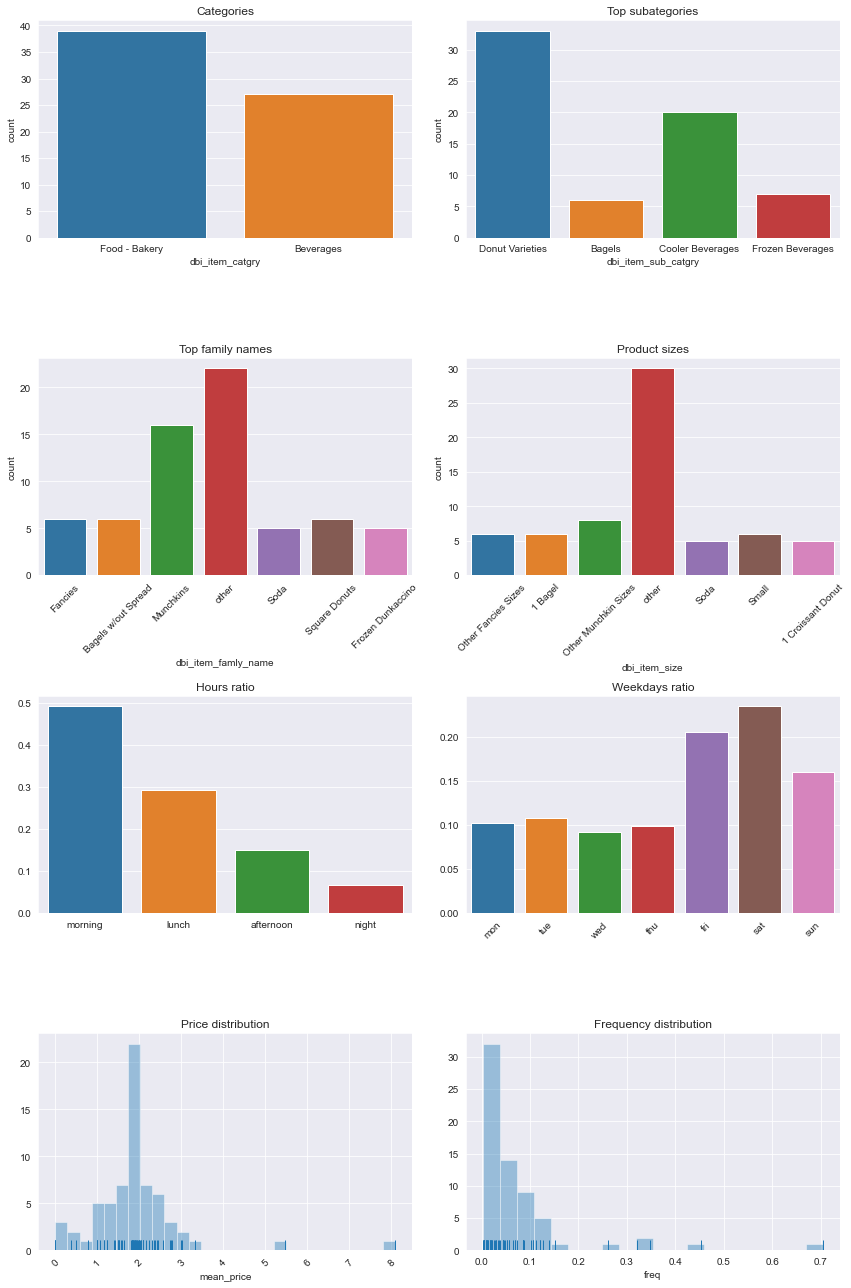

Cluster number: 2
Cluster size: 57

Mean price: 3.546
Mean stores count: 4.053
Mean freq: 0.024

Mean customers count: 2.807


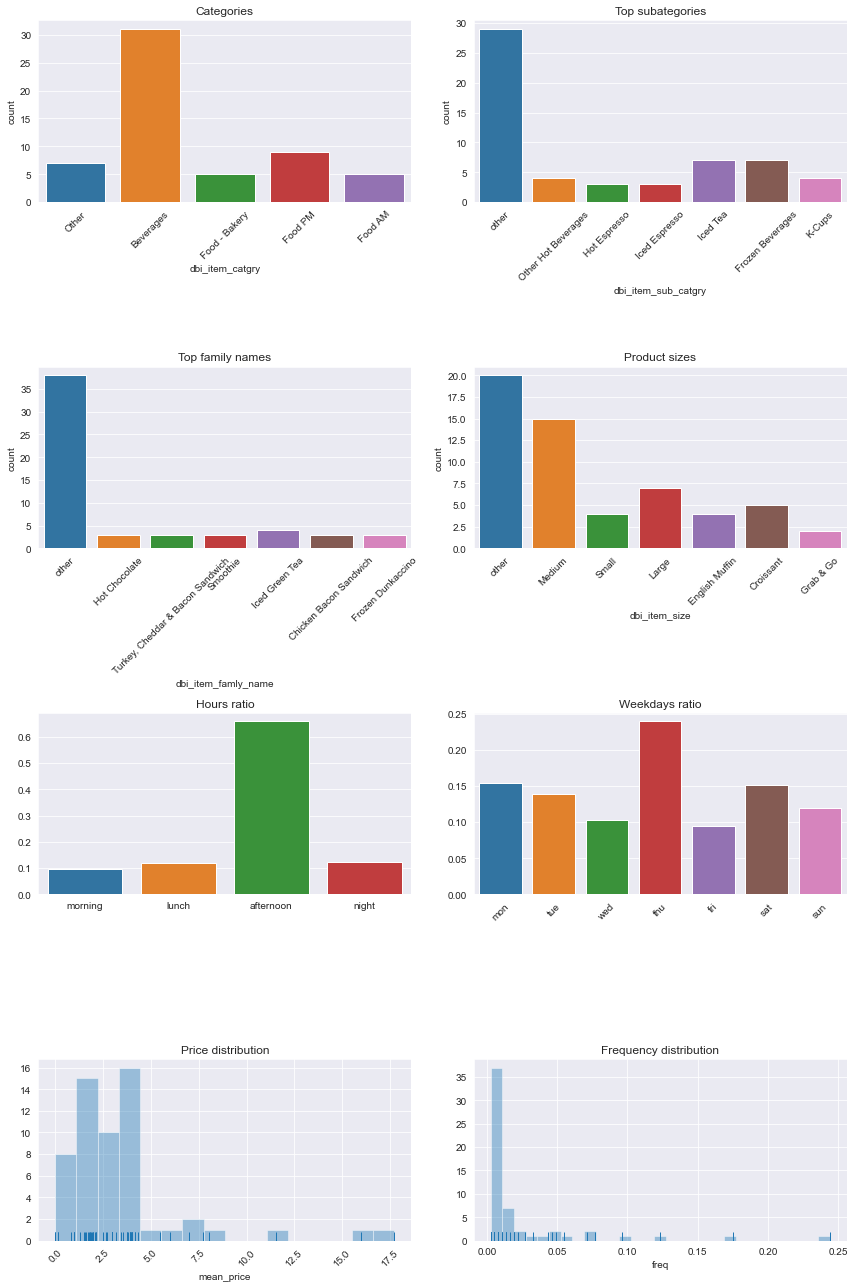

Cluster number: 3
Cluster size: 20

Mean price: 3.374
Mean stores count: 1.950
Mean freq: 0.008

Mean customers count: 1.750


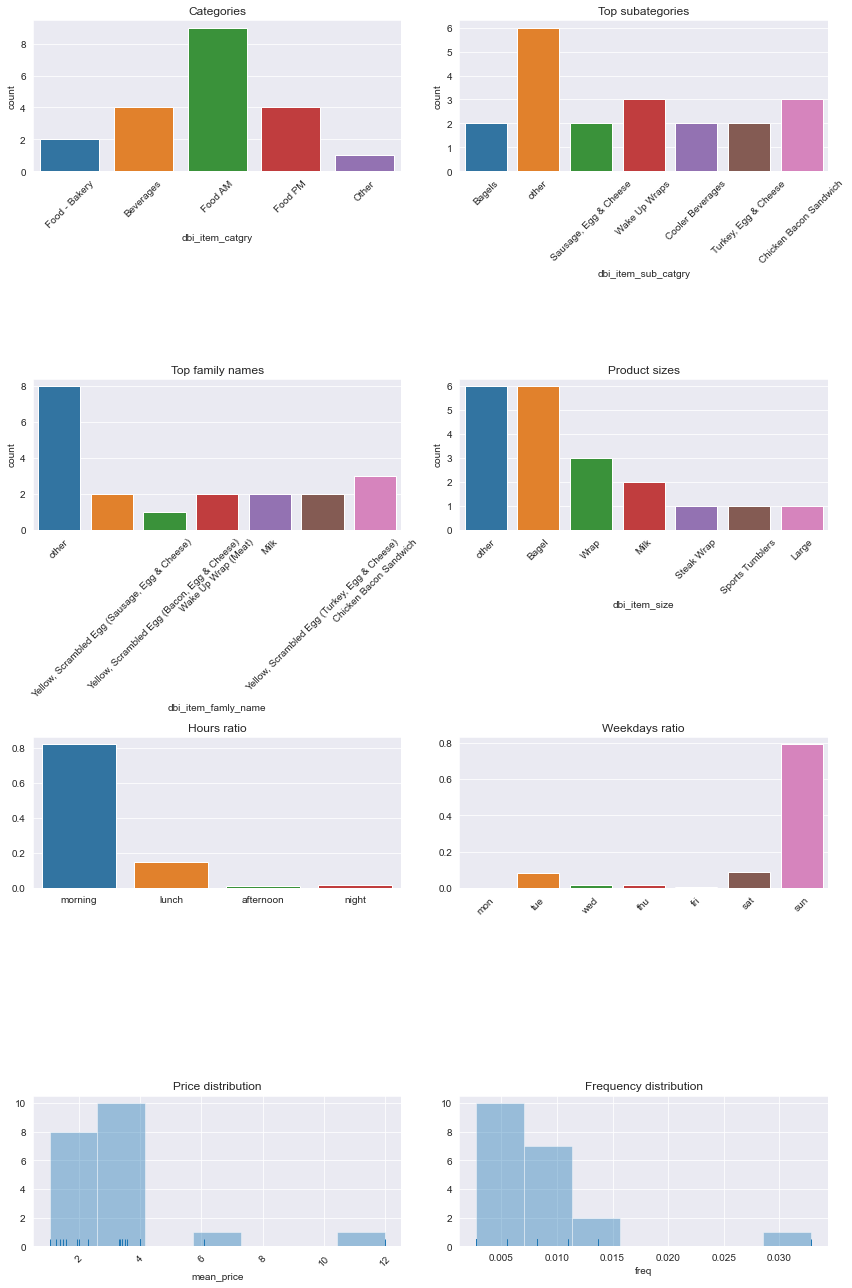

Cluster number: 4
Cluster size: 20

Mean price: 2.932
Mean stores count: 2.400
Mean freq: 0.010

Mean customers count: 2.000


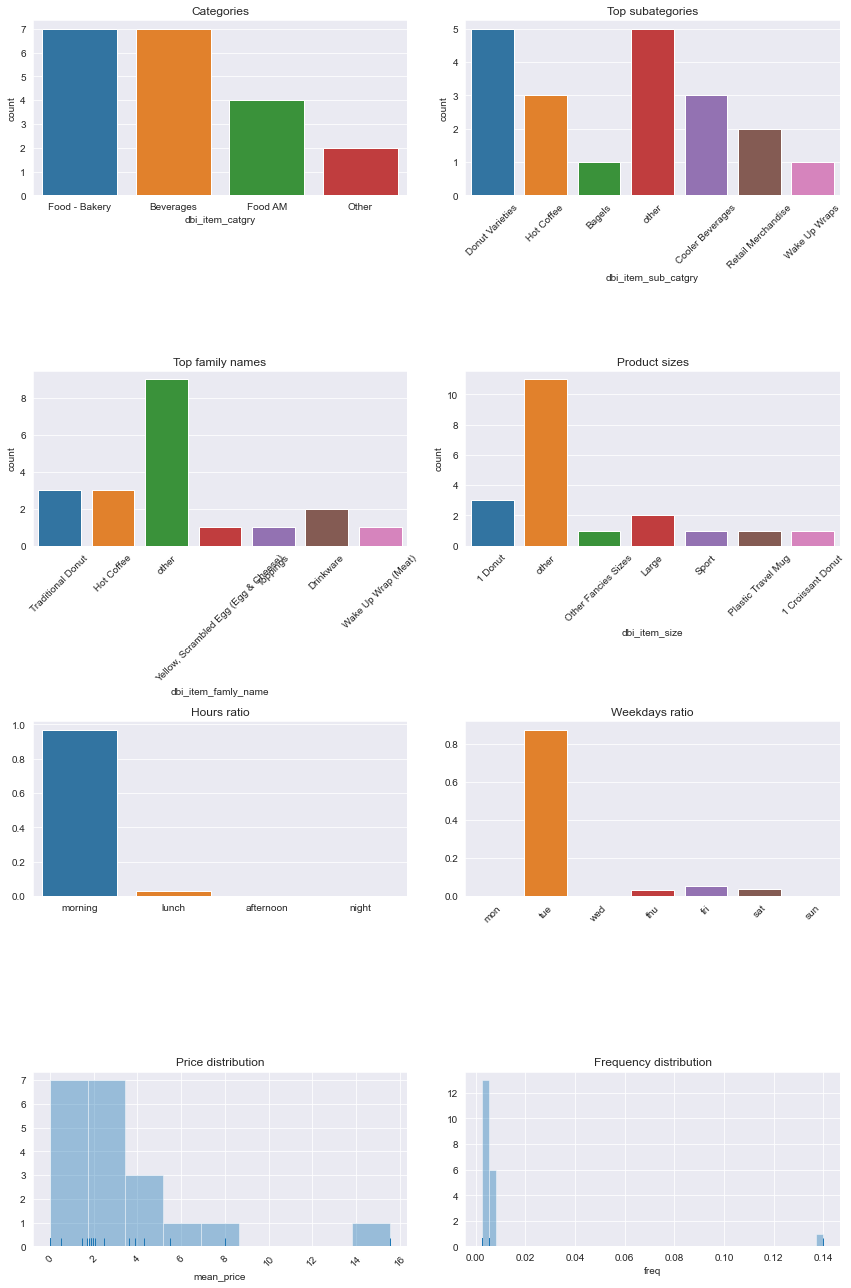

Cluster number: 5
Cluster size: 41

Mean price: 2.524
Mean stores count: 6.146
Mean freq: 0.028

Mean customers count: 4.317


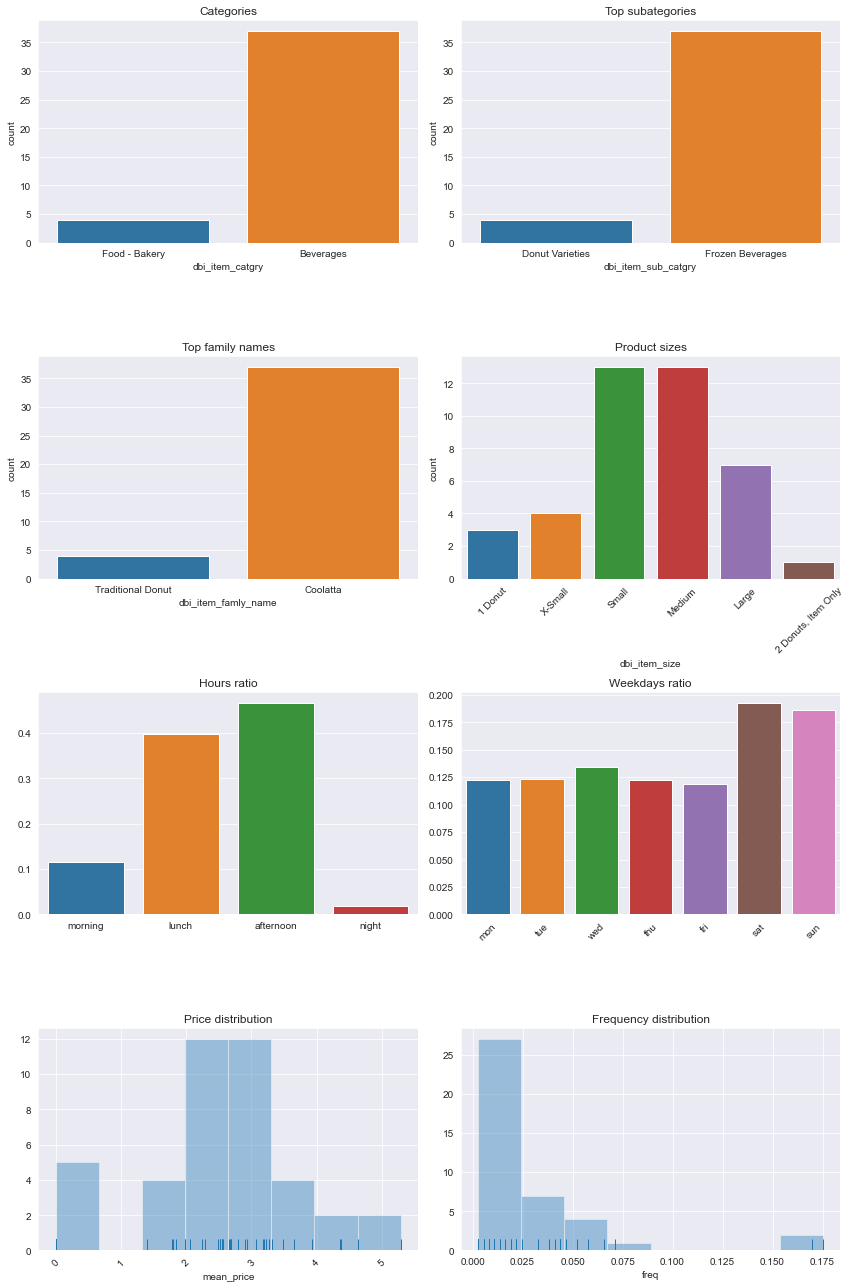

Cluster number: 6
Cluster size: 14

Mean price: 4.630
Mean stores count: 1.214
Mean freq: 0.004

Mean customers count: 1.143


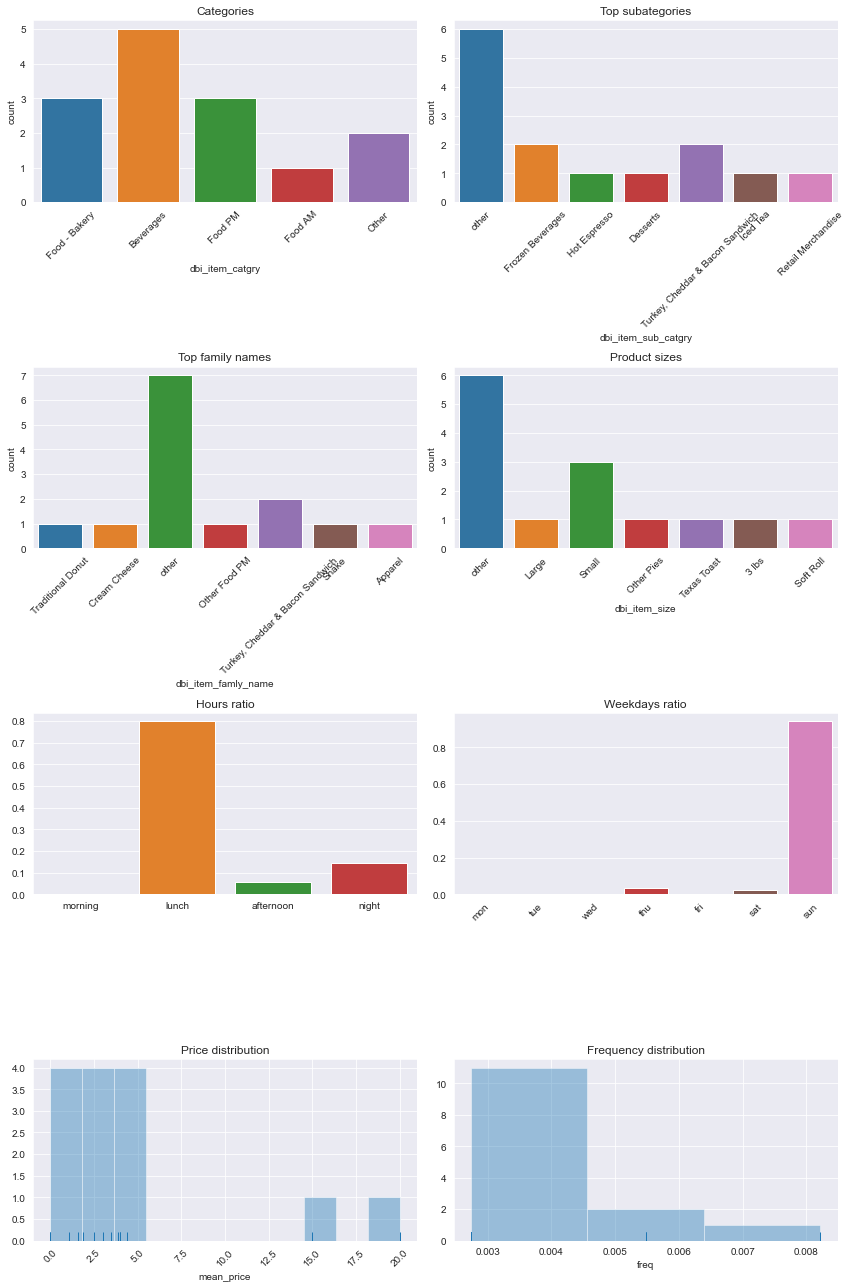

Cluster number: 7
Cluster size: 33

Mean price: 3.060
Mean stores count: 1.727
Mean freq: 0.009

Mean customers count: 1.545


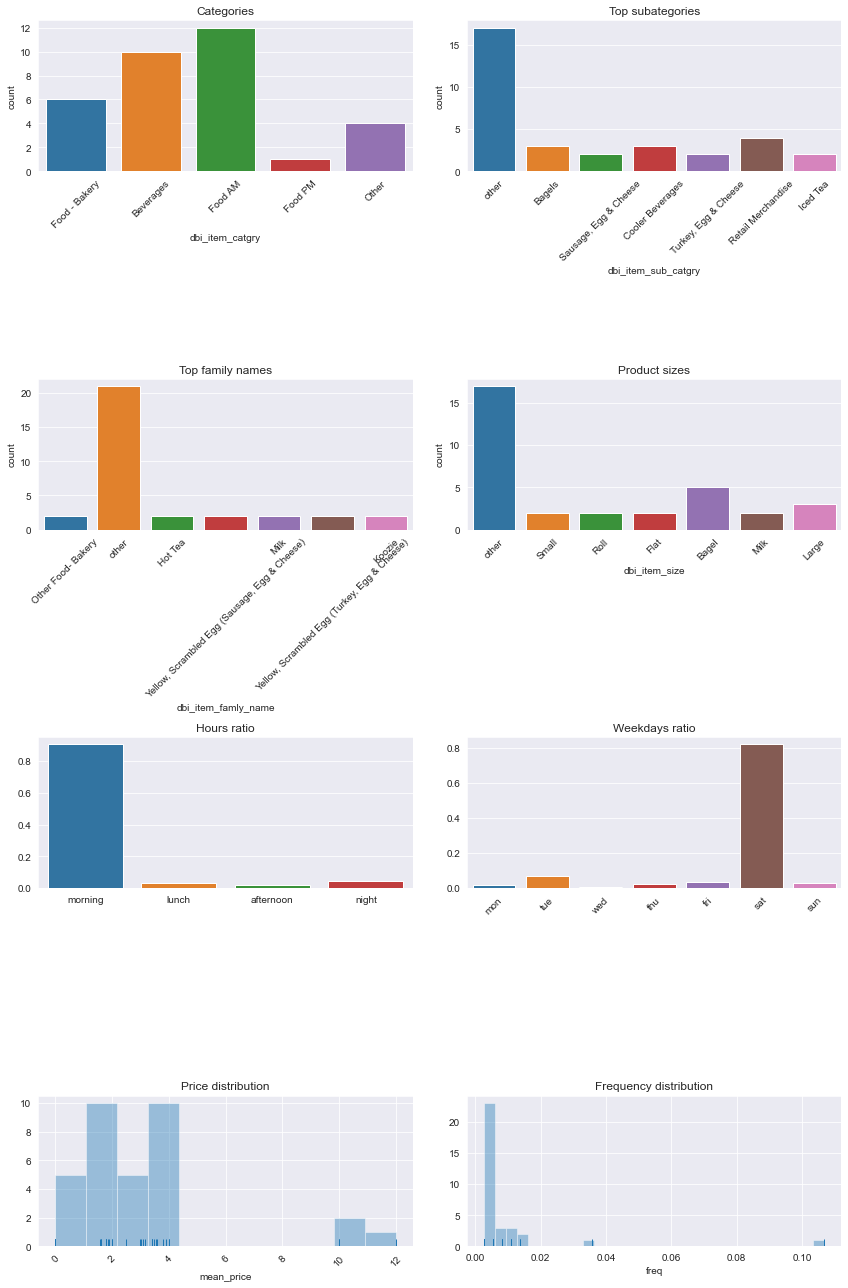

Cluster number: 8
Cluster size: 40

Mean price: 1.553
Mean stores count: 150.725
Mean freq: 0.725

Mean customers count: 42.150


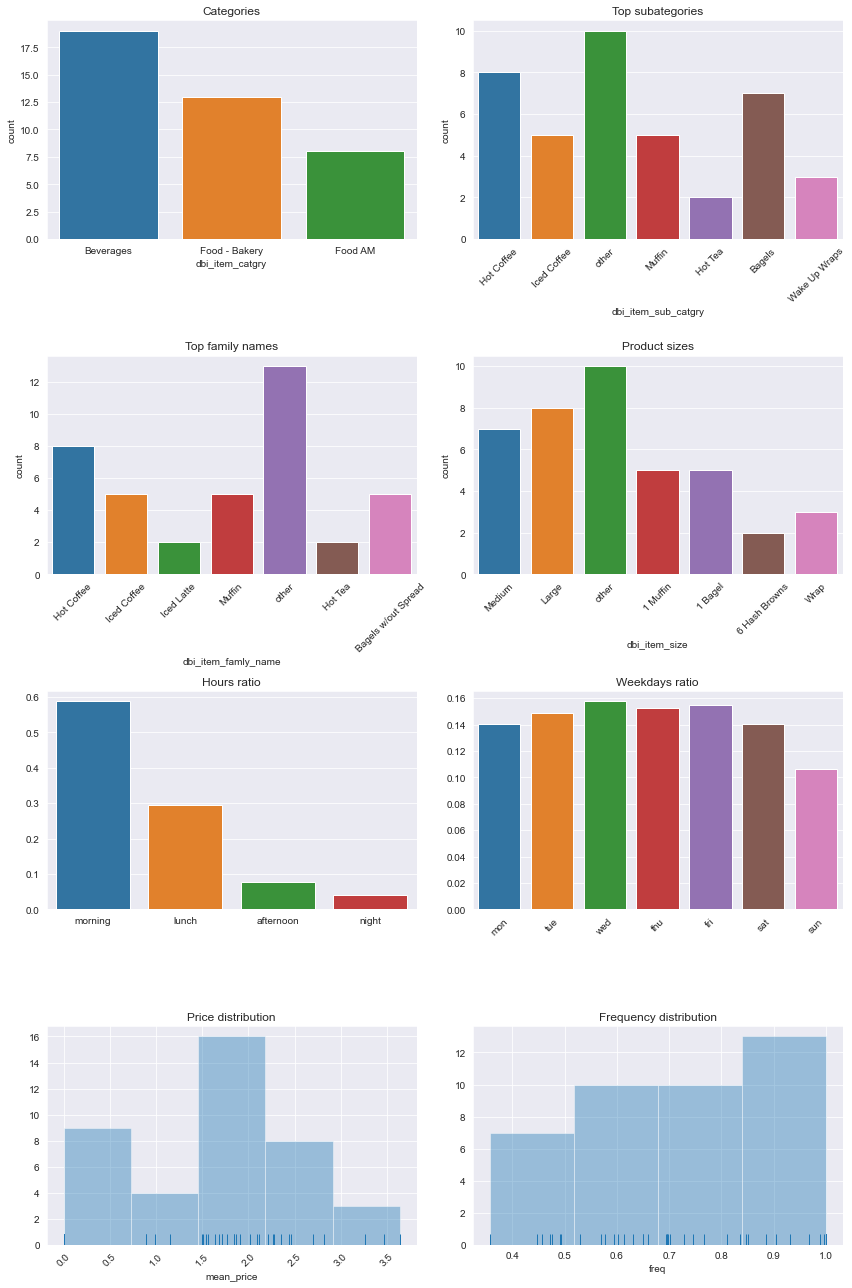

Cluster number: 9
Cluster size: 36

Mean price: 0.959
Mean stores count: 9.722
Mean freq: 0.065

Mean customers count: 6.417


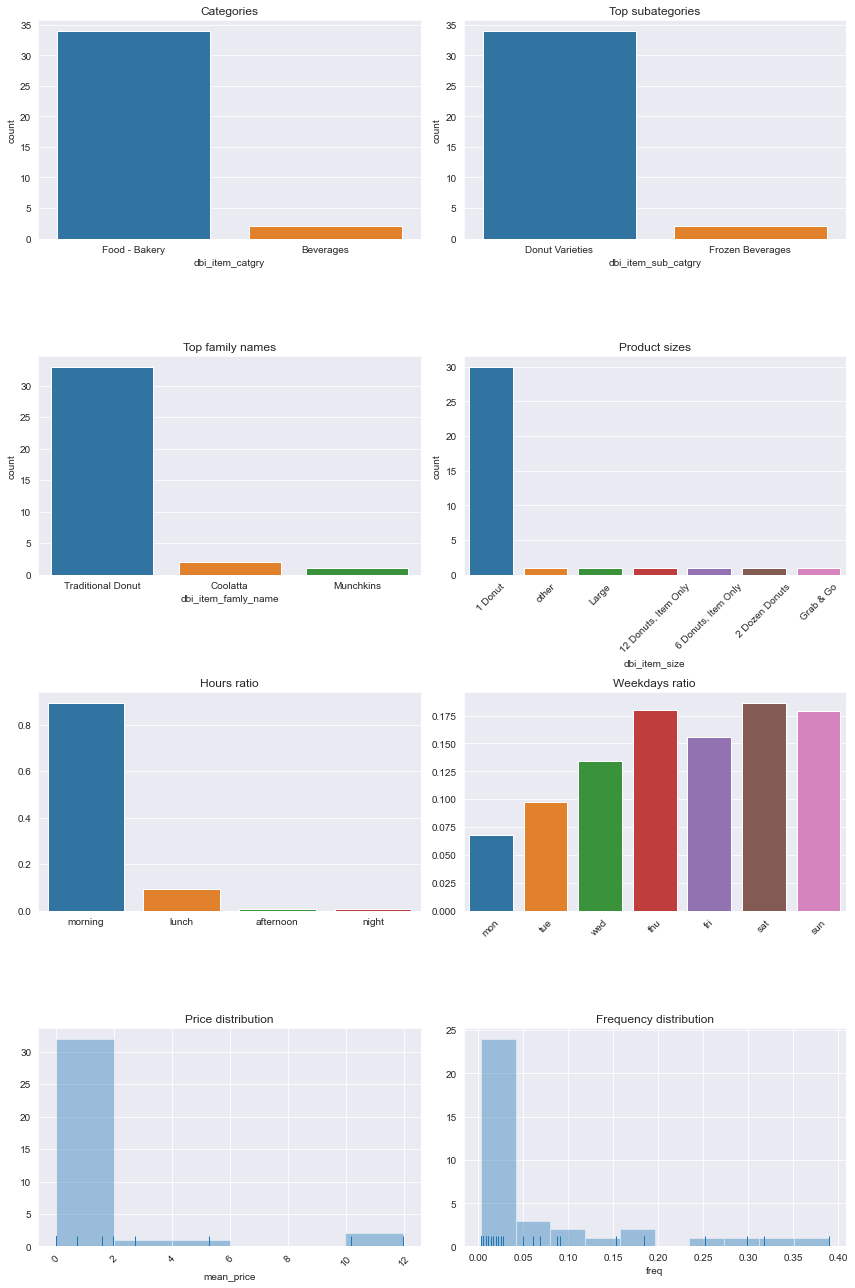

Cluster number: 10
Cluster size: 54

Mean price: 4.467
Mean stores count: 2.519
Mean freq: 0.026

Mean customers count: 2.000


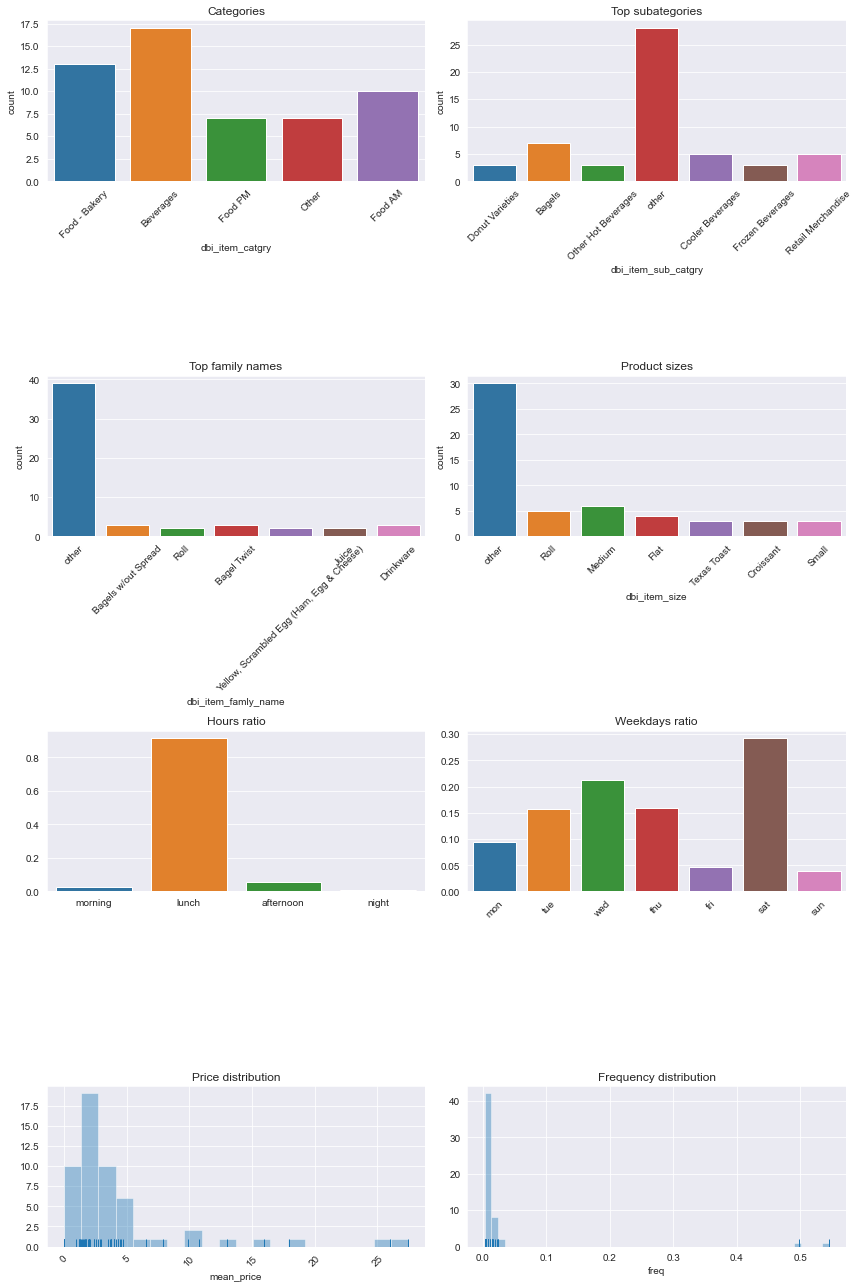

Cluster number: 11
Cluster size: 122

Mean price: 3.097
Mean stores count: 13.926
Mean freq: 0.081

Mean customers count: 8.287


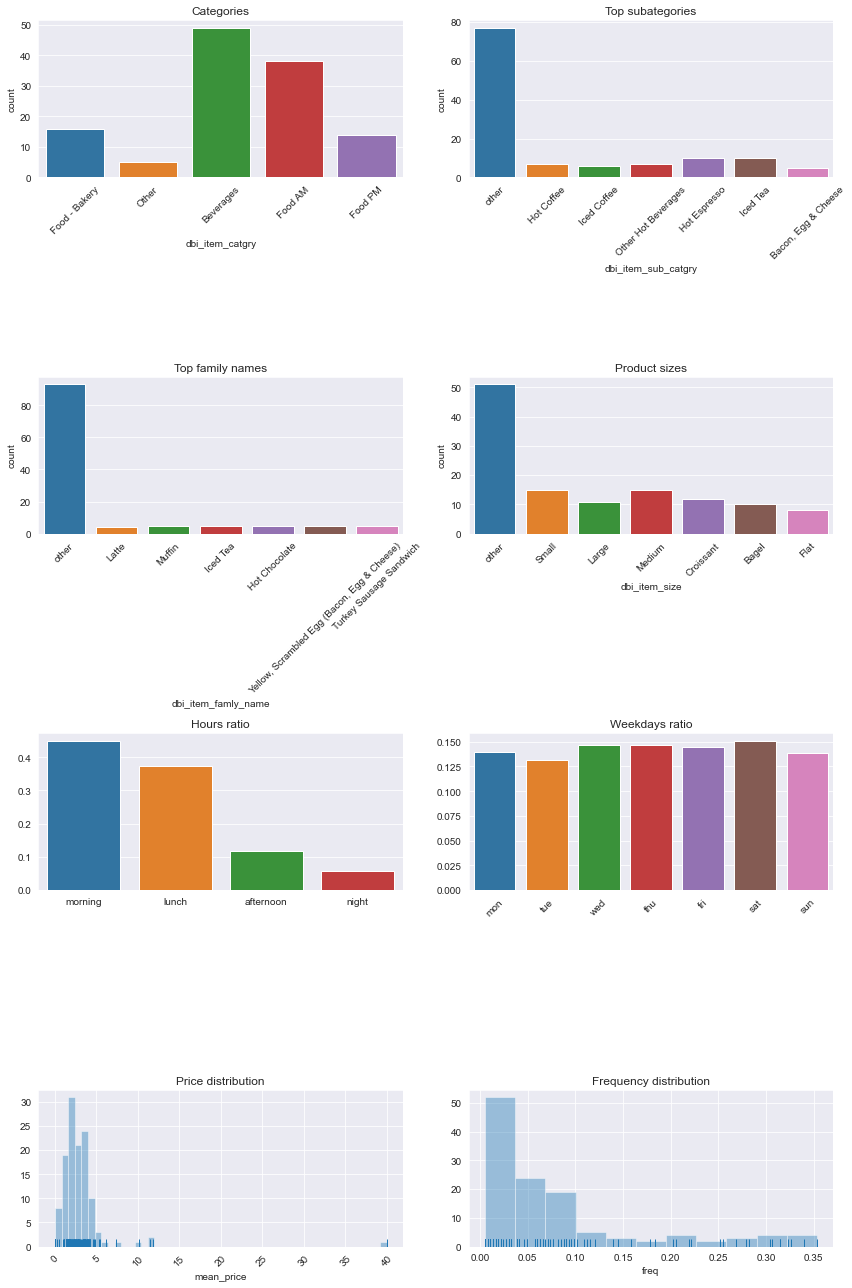

Cluster number: 12
Cluster size: 17

Mean price: 2.848
Mean stores count: 1.235
Mean freq: 0.005

Mean customers count: 1.235


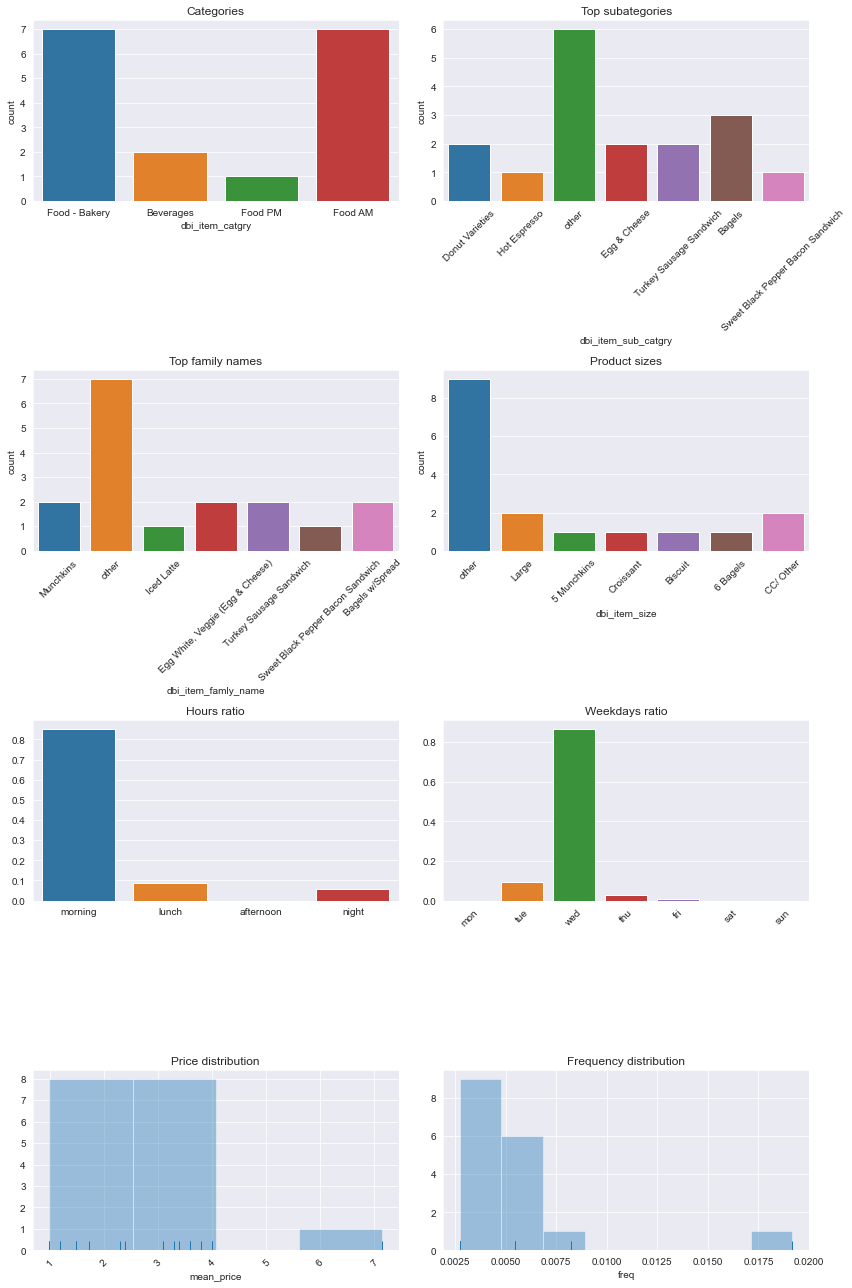

Cluster number: 13
Cluster size: 67

Mean price: 2.048
Mean stores count: 10.030
Mean freq: 0.094

Mean customers count: 5.776


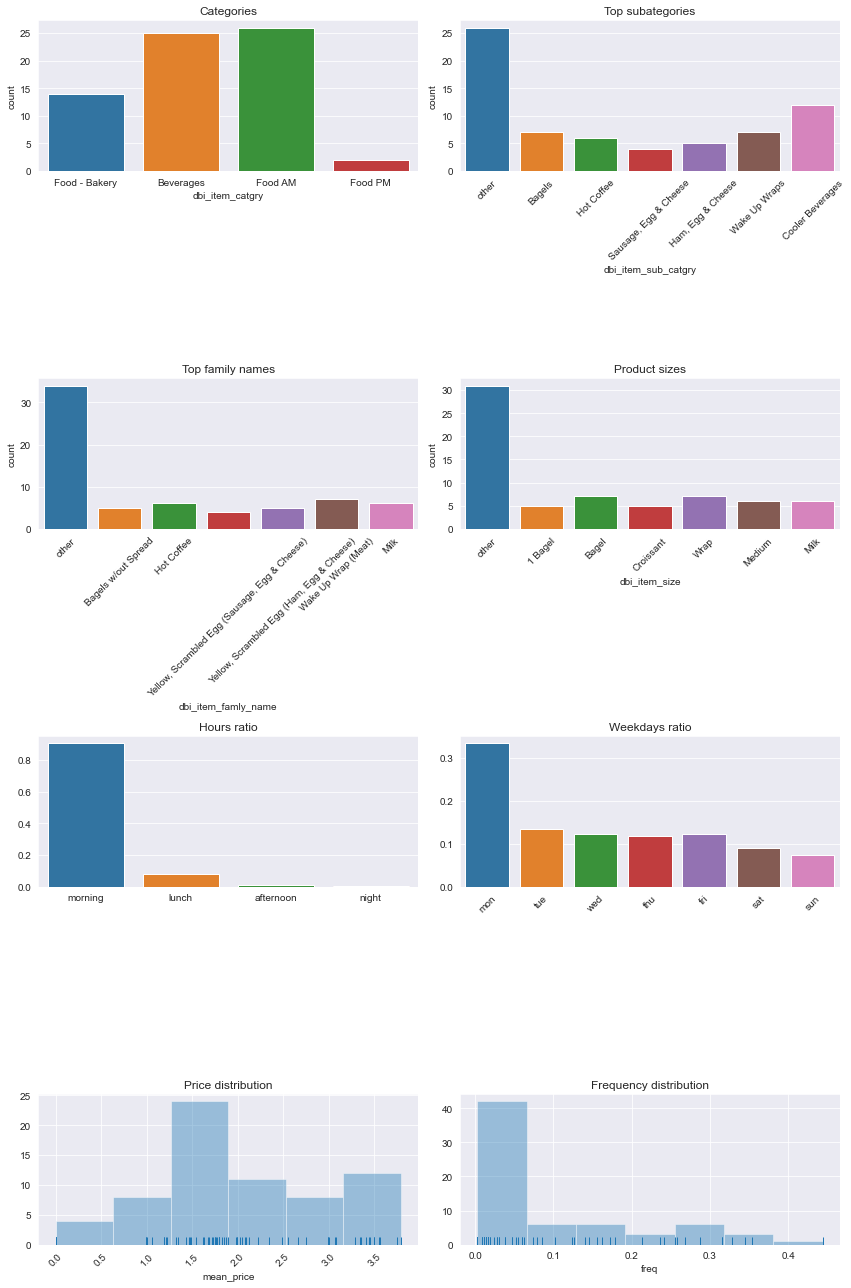

Cluster number: 14
Cluster size: 9

Mean price: 3.684
Mean stores count: 1.111
Mean freq: 0.003

Mean customers count: 1.111


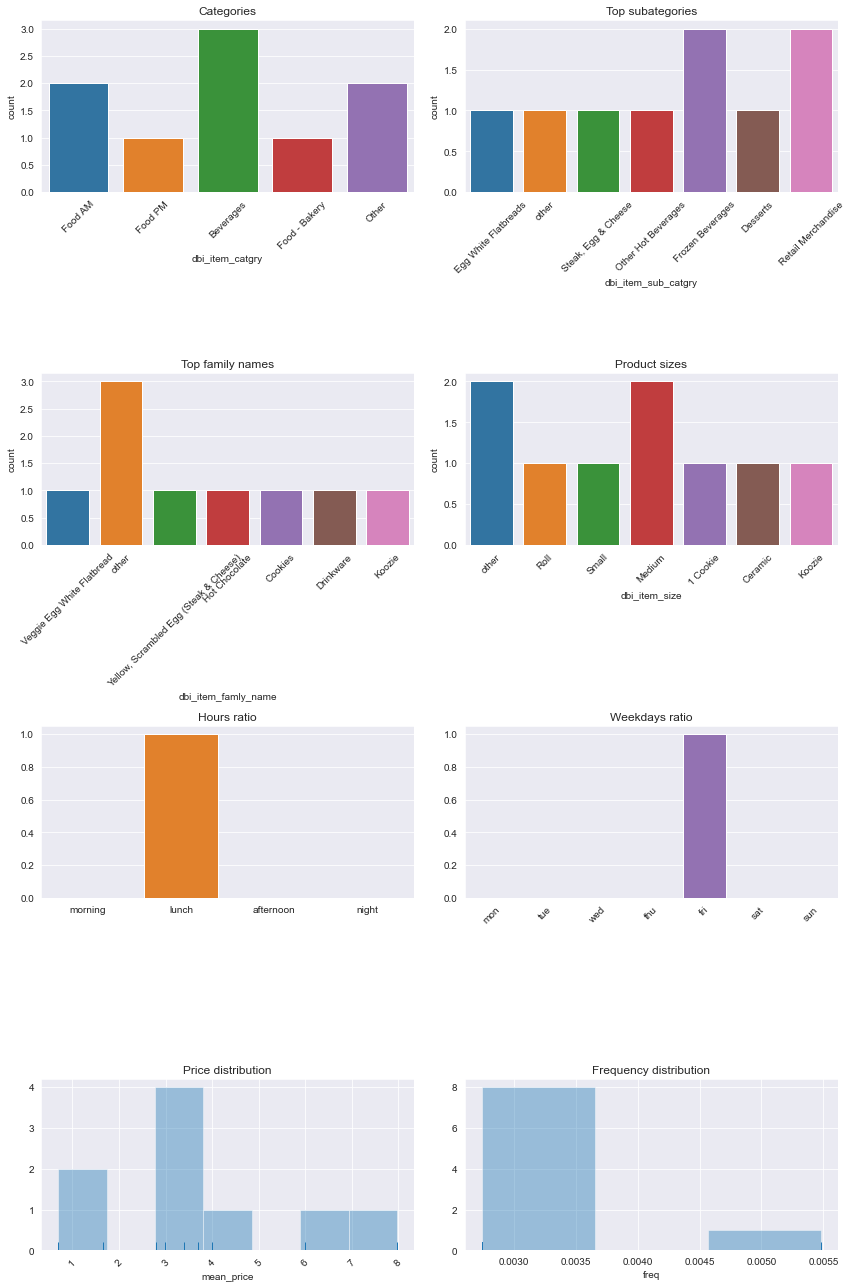

In [60]:
for k in sorted(scaled['kmeans_15'].unique()):
    describe_cluster(k, data, df, scaled['kmeans_15'])

#### Clusters description (15 clusters)

0. Mostly represented by AM food of moderate price which is occasionnaly bought for breakfast on Thursday and Friday by a small number of customers. Also includes beverages such as coffee. Products from this cluster are presented in a small number of stores.
1. Represents a combination of bakery (mostly donuts) and cold beverages, which mostly bought in first half of the day and have higher popularity during weekends.
2. Includes beverages (both hot and cold) and snacks that are bought together in the afternoon.
3. Represents morning and lunch food which is mostly bought on Sunday.
4. Morning beverages and bakery bought on Tuesday
5. Includes cold beverages which are usually bought for lunch or in the afternoon. Also includes a small amount of donut varieties which are bought in addition.
6. The second smallest cluster. Includes products that are bought for lunch on Sunday. These products are also pretty rare (presented only in a couple of stores)
7. Food and beverages that are occasionally bought in the morning on Saturday.
8. Represents beverages and products that are equally popular during the whole week. Also these products have the highest frequency of purchasing.
9. Bakery (mostly donuts) which are popular in the morning during the whole week. Also includes cold beverages which people usually take as an addition to a donut for a breakfast.
10. Products that are bought for lunch during working days and on Saturday.
11. The biggest cluster. Includes everyday products in such categories as beverages and AM foor but with less frequency of purchases comparing to 8. These products are also often purchased in higher quantity than items from 8.
12. Bakery and AM food which is sometimes purchased on Wednesdays in the morning.
13. Beverages, AM food and bakery that is bought on Mondays twice more often than on any other day.
14. The smalles cluster. Products are only purchased on Fridays for lunch. Mostly consists of beverages and AM food.